## ==================================================
# S2 (Direct-Recursive Strategy)
# M2 (MLP)
# Standard Code _ Version 1.5 / KISLAB @ Kookmin University
# ==================================================

# Basic Options (for Extended Experiment)

In [4]:
# 기본 설정값
SMCODE = "S2M2"    # S2(Direct-Recursive Strategy) + M2(MLP) 를 위한 Standard Code
PDCODE = "ONI"     # 품종코드
MDCODE = "MLP"     # 모델코드
PDNAME = "Onion"   # 품종명(영문)
VARS = 2           # 확장변수 사용여부 (1: 가격만 사용, 2: 거래량 추가사용)

# 학습 기본변수 설정
DROPOUT = 0.1   # Dropout 비율
EPOCH = 50    # 총 목표 학습횟수
PATIENCE = 5   # 학습 조기 중지를 위한 early stopping 옵션
BATCH = 32

# Special Option 설정
IRANGE = 365   # 가격 데이터를 입력으로 사용할 때 최대 총 며칠치 데이터를 사용할 것인지에 대한 옵션
SPLIT = 0      # 이 값을 0으로 설정할 경우, validation 수행하지 않음
WINSOR = 10   # 이상치 제거를 위한 Winsorizing 기준 설정 (단위: 퍼센트 / 이 값이 0일 경우, 이상치 제거 안함)

#BASEDATE = '2021-01-01'   # 검증용 데이터의 시작 시점 (D1을 위한 설정)
#USEDATE = '2021-12-31'    # 전체 사용할 데이터의 마지막 시점 (D1을 위한 설정)
BASEDATE = '2022-01-01'   # 검증용 데이터의 시작 시점 (D2를 위한 설정)
USEDATE = '2022-07-29'    # 전체 사용할 데이터의 마지막 시점 (D2를 위한 설정)

SELECTED = [5, 7]    # 예측모델을 개발할 선택 시점
NSEL = len(SELECTED)    # 예측모델을 개발할 선택 시점의 총 갯수


# ========= 결과 저장용 폴더 생성 ============== 

# System related and data input controls
import os

MODEL_DIR = 'MODEL_' + PDCODE + '_' + SMCODE + 'V' + str(VARS) + '_' + MDCODE
SCALE_DIR = 'SCALE_' + PDCODE + '_' + SMCODE + 'V' + str(VARS) + '_' + MDCODE

if os.path.exists(MODEL_DIR) == False:
    os.mkdir(f'{MODEL_DIR}')

if os.path.exists(SCALE_DIR) == False:
    os.mkdir(f'{SCALE_DIR}')

# ============= 데이터셋 로드 ================  

# Ignore the warnings
import warnings
#warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd

#load data
raw = pd.read_excel('(140103-220728)양파(양파(일반)).xlsx', usecols=['일자', '품종', '거래량(톤)', '도매가격(원/kg)'])
# raw = raw[raw['품종']=='양파(일반)']

#create 'datetime' column
if '일자' in raw.columns:
    raw['일자'] = pd.to_datetime(raw['일자'])
    raw['DateTime'] = pd.to_datetime(raw['일자'])

#set datetime to index 
if raw.index.dtype == 'int64':
    raw.set_index('DateTime',inplace=True)

raw.drop (['품종', '일자'], axis=1, inplace=True)
raw.columns = ['Price', 'Volume']
for i in range(0, raw.shape[0]):
    raw['Volume'][i] = raw['Volume'][i].replace(',','')
raw['Volume'] = raw['Volume'].astype('float32')

#fill missing date & values
raw.asfreq('D')[raw.asfreq('D').isnull().sum(axis=1) > 0]
raw = raw.asfreq('D', method='ffill')

# Load Library

In [5]:
# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

# Regression
from lightgbm import LGBMRegressor as lgb
import lightgbm as lgb

# Evaluation metrics for regression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import joblib
import tensorflow as tf

import datetime

In [6]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, Nadam
import keras

# Feature Engineering code

In [7]:
### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('D', method='ffill')
    raw['Price'].fillna(method='ffill',inplace=True)

    result = sm.tsa.seasonal_decompose(raw['Price'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['Price_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['Price_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'Price_trend' not in raw.columns:
        if 'Price_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)


    # STL분해 중 잔차 구하기
    result = sm.tsa.seasonal_decompose(raw['Price'], model='additive',period=30,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['Price_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)
    
    #시간 변수 만들기
    raw['year'] = pd.DatetimeIndex(raw.index).year
    raw['month'] = pd.DatetimeIndex(raw.index).month
    raw['day'] = pd.DatetimeIndex(raw.index).day
    raw['day_of_year'] = pd.DatetimeIndex(raw.index).dayofyear
    raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear
    raw['season'] = raw.month%12 // 3 + 1
    raw['Quarter'] = (raw.index.quarter)
    raw['Quarter_ver2'] =(raw['Quarter'] + (raw.year - raw.year.min()) * 4)
    if 'Quarter' in raw.columns:
        if 'Quarter_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quarter'], 
                                                 prefix='Quarter_Dummy', drop_first=True)], axis=1)
            del raw['Quarter']
    month_in_year = 12
    raw['month_sin'] = np.sin(2*np.pi*raw.month/month_in_year)
    raw['month_cos'] = np.cos(2*np.pi*raw.month/month_in_year)
    
    days_in_month = 30
    raw['day_sin'] = np.sin(2*np.pi*raw.day/days_in_month)
    raw['day_cos'] = np.cos(2*np.pi*raw.day/days_in_month)
    
    days_in_year = 365
    raw['day_of_year_sin'] = np.sin(2*np.pi*raw.day_of_year/days_in_year)
    raw['day_of_year_cos'] = np.cos(2*np.pi*raw.day_of_year/days_in_year)
    
    weeks_in_year = 52.1429
    raw['week_of_year_sin'] = np.sin(2*np.pi*raw.week_of_year/weeks_in_year)
    raw['week_of_year_cos'] = np.cos(2*np.pi*raw.week_of_year/weeks_in_year)
    
    seasons_in_year = 4
    raw['season_sin'] = np.sin(2*np.pi*raw.season/seasons_in_year)
    raw['season_cos'] = np.cos(2*np.pi*raw.season/seasons_in_year)
    raw.drop(['day', 'day_of_year', 'week_of_year', 'season'],axis=1,inplace=True)
    
    #가격 관련 변수 추가
    raw['rolling_mean_t30'] = raw['Price'].transform(lambda x: x.ewm(span=30,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t90'] = raw['Price'].transform(lambda x: x.ewm(span=90,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t180'] = raw['Price'].transform(lambda x: x.ewm(span=180,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t270'] = raw['Price'].transform(lambda x: x.ewm(span=270,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t365'] = raw['Price'].transform(lambda x: x.ewm(span=365,min_periods=1,adjust=True,ignore_na=False).mean())
    
    #for a in range(1,366):
    #    raw[f'Price_lag{a}'] = raw['Price'].shift(a)
    #    raw[f'Price_lag{a}'].fillna(0,inplace=True)
    
    raw['P_diff']=raw['Price'].diff(1)
    raw['P_diff'].fillna(0,inplace=True)
#    raw['Year_a_go'] = raw['Price'].shift(365)
#    raw['Y_diff'] = raw['Price']-raw['Year_a_go']
    raw['P_sum'] = raw['Price']+raw['P_diff']

    raw['month'] =(raw['month'] + (raw.year - raw.year.min()) * 12)
    mapd = raw.groupby('month')['Price'].mean()
    mapd = pd.DataFrame(mapd,index=mapd.index)  
    mapd.reset_index(drop=False,inplace=True)
    mapd.columns=['month','Mapd']
    raw = pd.merge(raw,mapd,how='left',left_on='month',right_on='month')
    raw['R_p'] = raw['Price']-raw['Mapd']
    
    raw.drop(['Mapd'],axis=1,inplace=True)
    
    return raw

# Data Partitioning

In [8]:
# Raw dataset selection
raw=raw[raw.index <= USEDATE]

# Train,Test split
test=raw[raw.index >= BASEDATE]
train=raw[raw.index < BASEDATE]
raw_idx = raw.index
train_idx = train.index

df = raw.copy()
df = df[['Volume', 'Price']]

VS = df.copy()
VS = VS.drop(['Price'], axis=1)
VS['Volume'] = VS['Volume'].shift(1)

y_test = test['Price']

# MLP with FE

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 393)               154842    
                                                                 
 dropout (Dropout)           (None, 393)               0         
                                                                 
 dense_1 (Dense)             (None, 786)               309684    
                                                                 
 dropout_1 (Dropout)         (None, 786)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 787       
                                                                 
Total params: 465,313
Trainable params: 465,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 197477.6250 - 795ms/

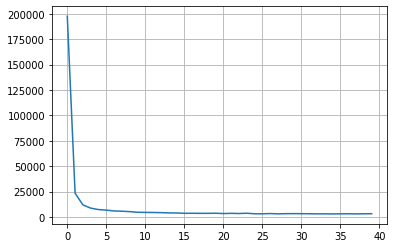

79/79 [==============================] - 0s 3ms/step


 14%|████████████                                                                        | 1/7 [00:15<01:30, 15.09s/it]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 393)               154842    
                                                                 
 dropout_2 (Dropout)         (None, 393)               0         
                                                                 
 dense_4 (Dense)             (None, 786)               309684    
                                                                 
 dropout_3 (Dropout)         (None, 786)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 787       
                                                                 
Total params: 465,313
Trainable params: 465,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 190078.9062 - 695m

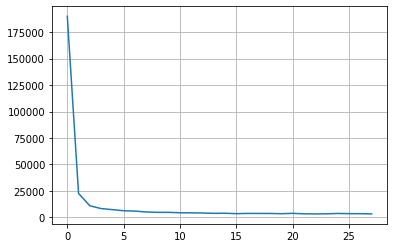

79/79 [==============================] - 0s 3ms/step


 29%|████████████████████████                                                            | 2/7 [00:25<01:01, 12.33s/it]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 393)               154842    
                                                                 
 dropout_4 (Dropout)         (None, 393)               0         
                                                                 
 dense_7 (Dense)             (None, 786)               309684    
                                                                 
 dropout_5 (Dropout)         (None, 786)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 787       
                                                                 
Total params: 465,313
Trainable params: 465,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 195563.4531 - 675m

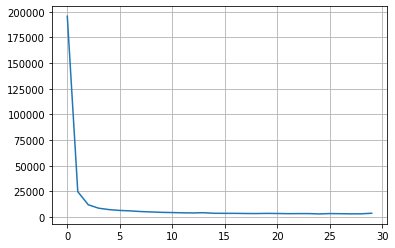

79/79 [==============================] - 0s 2ms/step


 43%|████████████████████████████████████                                                | 3/7 [00:36<00:46, 11.56s/it]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 393)               154842    
                                                                 
 dropout_6 (Dropout)         (None, 393)               0         
                                                                 
 dense_10 (Dense)            (None, 786)               309684    
                                                                 
 dropout_7 (Dropout)         (None, 786)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 787       
                                                                 
Total params: 465,313
Trainable params: 465,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 199128.6250 - 647m

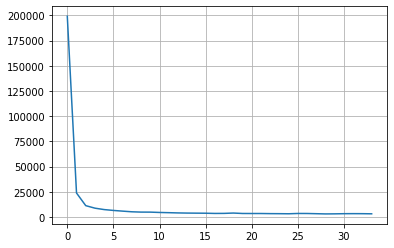

79/79 [==============================] - 0s 2ms/step


 57%|████████████████████████████████████████████████                                    | 4/7 [00:47<00:34, 11.66s/it]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 393)               154842    
                                                                 
 dropout_8 (Dropout)         (None, 393)               0         
                                                                 
 dense_13 (Dense)            (None, 786)               309684    
                                                                 
 dropout_9 (Dropout)         (None, 786)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 787       
                                                                 
Total params: 465,313
Trainable params: 465,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 199496.8281 - 673m

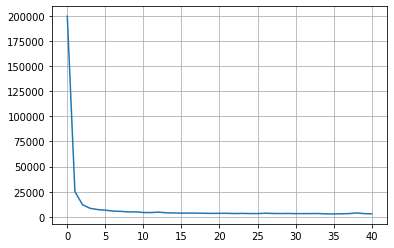

79/79 [==============================] - 0s 2ms/step


 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:02<00:25, 12.65s/it]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 393)               154842    
                                                                 
 dropout_10 (Dropout)        (None, 393)               0         
                                                                 
 dense_16 (Dense)            (None, 786)               309684    
                                                                 
 dropout_11 (Dropout)        (None, 786)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 787       
                                                                 
Total params: 465,313
Trainable params: 465,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 202328.0625 - 660m

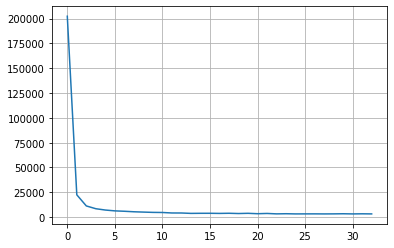

79/79 [==============================] - 0s 2ms/step


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [01:16<00:13, 13.22s/it]

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 393)               154842    
                                                                 
 dropout_12 (Dropout)        (None, 393)               0         
                                                                 
 dense_19 (Dense)            (None, 786)               309684    
                                                                 
 dropout_13 (Dropout)        (None, 786)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 787       
                                                                 
Total params: 465,313
Trainable params: 465,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 205041.8281 - 639m

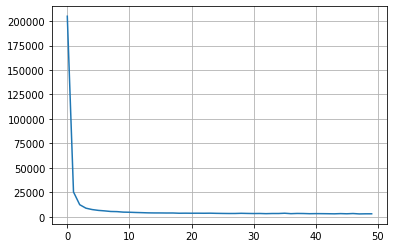

79/79 [==============================] - 0s 2ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:32<00:00, 13.28s/it]


In [9]:
VERBOSE = 2

with tf.device("/device:CPU:0"):
    
    for day_num in tqdm(range(1, 1 + max(SELECTED))):

        if day_num == 1:
                        
            train_all = []
            train_all = raw.iloc[:,:1]

            # Price에 Outlier Treatment 적용 ---------------------#

            winsor_list = []
            winsor_list.append(WINSOR)
            winsor_list.append(100 - WINSOR)

            winsors = np.percentile(train_all['Price'][train_all.index < BASEDATE], winsor_list)
            winsor_min = winsors[0]
            winsor_max = winsors[1]

            train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] < winsor_min, winsor_min, train_all['Price'][train_all.index < BASEDATE])
            train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] > winsor_max, winsor_max, train_all['Price'][train_all.index < BASEDATE])

            #-----------------------------------------------------#

            V = pd.DataFrame(columns=['V'],index=raw.index)
            for i in range(day_num, IRANGE + day_num):
                train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)

            raw_all = train_all.iloc[day_num:]
            raw_seed = raw_all.iloc[:,1:2]
            raw_seed.columns=['Price']
            raw_seed = feature_engineering(raw_seed)
            seed = raw_seed.iloc[:,1:]
            seed.index = raw_idx[day_num:]

            if VARS == 2:  # 거래량을 사용할 경우에만 처리
                V['Volume'] = raw['Volume'].shift(day_num)
                V['Volume'].iloc[day_num:]
                raw_final = pd.concat([raw_all, seed, V['Volume']],axis=1)
            else:
                raw_final = pd.concat([raw_all, seed],axis=1)

            raw_final = raw_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

            train_new = raw_final[raw_final.index < BASEDATE]
            test_new = raw_final[raw_final.index >= BASEDATE]

            y_train_raw = train_new['Price']
            x_train_raw = train_new.drop(['Price'],axis=1)   

            # Min-Max Normalization 적용
            scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
            X_train = scaler_X_tr.fit_transform(x_train_raw)
                        
            joblib.dump(scaler_X_tr,f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}.save')

            
            # Validation 데이터을 학습에 사용할 경우에 대한 처리        

            if SPLIT == 0:
                x_train = X_train
                y_train = y_train_raw
            else:
                x_train = X_train[:-SPLIT]
                y_train = y_train_raw[:-SPLIT]
                x_valid = X_train[-SPLIT:]
                y_valid = y_train_raw[-SPLIT:]        

            # MLP Training

            model = Sequential()
            model.add(Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='elu'))
            model.add(Dropout(DROPOUT))
            model.add(Dense(2*(X_train.shape[1]), activation='elu'))
            model.add(Dropout(DROPOUT))
            model.add(Dense(1,activation='linear'))
            model.compile(optimizer='adam', loss='mean_squared_error')
            model.summary()

            if SPLIT == 0:
                ES = EarlyStopping(monitor='loss', mode='min', patience=PATIENCE, restore_best_weights=True)        
                model_fit = model.fit(x_train, y_train, 
                                      batch_size=BATCH, epochs=EPOCH, callbacks=ES,
                                      verbose=VERBOSE)
            else:
                ES = EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)        
                model_fit = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                                      batch_size=BATCH, epochs=EPOCH, callbacks=ES,
                                      verbose=VERBOSE)            
            
            # Save model
            model.save(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}')

            plt.plot(pd.DataFrame(model_fit.history))
            plt.grid(True)
            plt.show()            
            
            # Prediction
            Y_train_pred = model.predict(X_train)

        else:

            train_all = []
            train_all = raw.iloc[:,:1]

            V = pd.DataFrame(columns=['V'],index=raw.index)
            for i in range(day_num, IRANGE + 1):
                train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)

            train_new = train_new.iloc[:,:day_num-1]

            for call_train in range(1, day_num-1):
                train_new[f'Y_{call_train}pred'] = train_new[f'Y_{call_train}pred'].shift(1)

            train_new[f'Y_{day_num-1}pred'] = 0
            train_new[f'Y_{day_num-1}pred'] = Y_train_pred
            train_new[f'Y_{day_num-1}pred'] = train_new[f'Y_{day_num-1}pred'].shift(1)

            new = train_new.columns[-1:].to_list()
            Price = train_new.columns[:1].to_list()
            old = train_new.columns[1:day_num-1].to_list()
            new_col = Price + new + old
            train_new = train_new[new_col]

            train_new.fillna(method='bfill',inplace=True)

            raw_all = train_all.iloc[day_num:]
            raw_seed = raw_all.iloc[:,1:2]
            raw_seed.columns=['Price']
            raw_seed = feature_engineering(raw_seed)
            seed = raw_seed.iloc[:,1:]
            seed.index = raw_idx[day_num:]

            train_all = train_all.drop('Price', axis=1)

            if VARS == 2:  # 거래량을 사용할 경우에만 처리
                V['Volume'] = raw['Volume'].shift(day_num)
                V['Volume'].iloc[day_num:]
                raw_final = pd.concat([train_new, train_all, seed, V['Volume']],axis=1)
            else:
                raw_final = pd.concat([train_new, train_all, seed],axis=1)

            raw_final = raw_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

            train_new = raw_final[raw_final.index < BASEDATE]
            test_new = raw_final[raw_final.index >= BASEDATE]        

            # Min-Max Normalization 적용
            scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
            X_train = scaler_X_tr.fit_transform(x_train_raw)
                        
            joblib.dump(scaler_X_tr,f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}.save')
                

            # Validation 데이터을 학습에 사용할 경우에 대한 처리        

            if SPLIT == 0:
                x_train = X_train
                y_train = y_train_raw
            else:
                x_train = X_train[:-SPLIT]
                y_train = y_train_raw[:-SPLIT]
                x_valid = X_train[-SPLIT:]
                y_valid = y_train_raw[-SPLIT:]        

            # MLP Training

            model = Sequential()
            model.add(Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='elu'))
            model.add(Dropout(DROPOUT))
            model.add(Dense(2*(X_train.shape[1]), activation='elu'))
            model.add(Dropout(DROPOUT))
            model.add(Dense(1,activation='linear'))
            model.compile(optimizer='adam', loss='mean_squared_error')
            model.summary()

            if SPLIT == 0:
                ES = EarlyStopping(monitor='loss', mode='min', patience=PATIENCE, restore_best_weights=True)        
                model_fit = model.fit(x_train, y_train, 
                                      batch_size=BATCH, epochs=EPOCH, callbacks=ES,
                                      verbose=VERBOSE)
            else:
                ES = EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)        
                model_fit = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                                      batch_size=BATCH, epochs=EPOCH, callbacks=ES,
                                      verbose=VERBOSE)            
            
            # Save model
            model.save(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}')

            plt.plot(pd.DataFrame(model_fit.history))
            plt.grid(True)
            plt.show()            
            
            # Prediction
            Y_train_pred = model.predict(X_train)

# MLP with FE / Inference

In [28]:
import datetime
print(datetime.datetime.now())

pred = []
DCNT = test.shape[0]

scaler = []
load_model = []

pos = 0

# lag변수 생성 
for i in range(1, IRANGE + 1):
    df[f'Price{i}lag'] = df['Price'].shift(i)


# Scaler 및 Model 사전 메모리 로드
for m in range(1, max(SELECTED) + 1):
    scaler_temp = joblib.load(f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{m}.save')
    model_temp = keras.models.load_model(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{m}')
    
    scaler.append(scaler_temp)
    load_model.append(model_temp)

    
with tf.device("/device:GPU:0"):  

    for day_num in tqdm(SELECTED):
        
        pos = pos + 1
        pred_list = []

        for valid_day in range(0, DCNT):
            
            target_date = test.index[0] + datetime.timedelta(days = -day_num + valid_day)
            df_x = df.iloc[df.index <= target_date, 2:]
            seed = df_x.iloc[:, 0:1]
            seed.columns=['Price']
            seed.fillna(method='bfill', inplace=True)
            df_fe = feature_engineering(seed)
            df_fe.index = df_x.index 

            V = VS[VS.index == target_date]
            
            for model_day in range(1, day_num + 1):                
                
                if model_day == 1:

                    test_old = df_x[-1:]
                    test_new = df_fe[-1:].drop('Price', axis=1)

                    if VARS == 2:  # 거래량을 사용할 경우에만 처리
                        raw_final = pd.concat([test_old, test_new, V['Volume']],axis=1)
                    else:
                        raw_final = pd.concat([test_old, test_new],axis=1)

                    x_test = scaler[model_day-1].transform(raw_final)
                    y_test_pred = load_model[model_day-1].predict(x_test, verbose=0)

                    temp = raw_final.iloc[:, 0:IRANGE]                    
                                        
                else:
                    
                    temp.index = temp.index + datetime.timedelta(days=1)

                    for mov in range(IRANGE, 2, -1):
                        temp[f'Price{mov}lag'] = temp[f'Price{mov-1}lag']

                    temp['Price1lag'] = y_test_pred
                    df_x = df_x.append(temp)

                    seed = df_x.iloc[:, 0:1]
                    seed.columns=['Price']
                    seed.fillna(method='bfill', inplace=True)
                    df_fe = feature_engineering(seed)
                    df_fe.index = df_x.index

                    test_old = df_x[-1:]
                    test_new = df_fe[-1:].drop('Price', axis=1)
                    V.index = temp.index

                    if VARS == 2:  # 거래량을 사용할 경우에만 처리
                        raw_final = pd.concat([test_old, test_new, V['Volume']],axis=1)
                    else:
                        raw_final = pd.concat([test_old, test_new],axis=1)

                    x_test = scaler[model_day-1].transform(raw_final)
                    y_test_pred = load_model[model_day-1].predict(x_test, verbose=0)
            
            pred_list.append(y_test_pred[0])

        pred.append(pred_list)

print(datetime.datetime.now())

2022-08-08 23:10:25.984257


 30%|████████████████████████▋                                                        | 64/210 [00:42<01:36,  1.52it/s]


 62%|█████████████████████████████████████████████████▌                              | 130/210 [01:26<00:52,  1.53it/s]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 196/210 [02:09<00:09,  1.54it/s]


 24%|███████████████████▎                                                             | 50/210 [00:46<02:28,  1.08it/s]


 55%|████████████████████████████████████████████▏                                   | 116/210 [01:47<01:28,  1.07it/s]


 87%|█████████████████████████████████████████████████████████████████████▎          | 182/210 [02:51<00:27,  1.01it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [05:37<00:00, 168.87s/it]

2022-08-08 23:16:06.215960


# MLP with FE / Visualization

Model5 Results



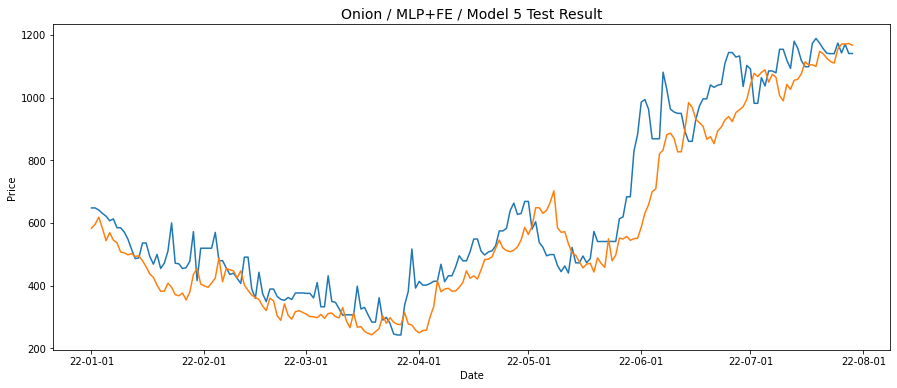

MAPE=13.421892939084442
RMSE=103.5877404209619



Model7 Results



<Figure size 432x288 with 0 Axes>

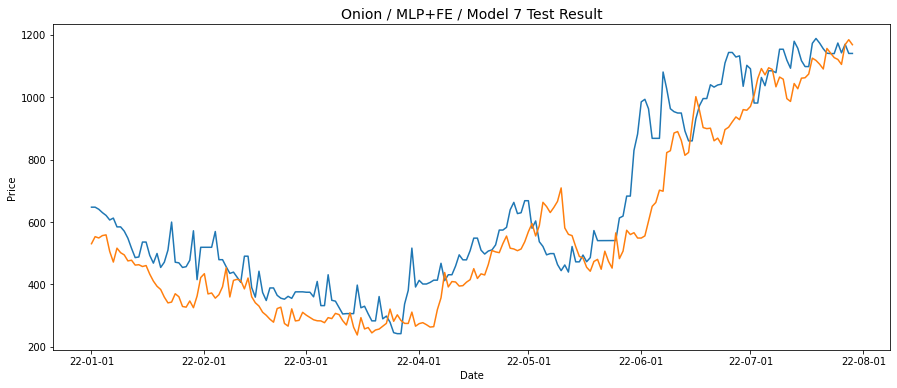

<Figure size 432x288 with 0 Axes>

MAPE=16.040911929340538
RMSE=119.29312944981599





In [30]:
for i in range(0, NSEL):
    
    print(f'Model{SELECTED[i]} Results\n')

    plot_data = pd.DataFrame([y_test.values, pred[i]]).T
    date_label = pd.date_range(start=y_test.index[0], end=y_test.index[-1], freq='D')
    
    fig, ax = plt.subplots(figsize=(15,6))
        
    plot_data.columns = ['actual','pred']
    ax.plot(date_label, plot_data)
    
    plt.title(PDNAME + ' / ' + MDCODE + '+FE / Model ' + str(SELECTED[i]) + ' Test Result', fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)
    
    dateFmt = mdates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(dateFmt)
    
    plt.show()
    plt.clf()
    
    MAPE = mean_absolute_percentage_error(y_test.values.flatten(), pred[i])*100
    print(f'MAPE={MAPE}')

    RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(), pred[i]))
    print(f'RMSE={RMSE}\n\n\n')

# MLP without FE

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 366)               134322    
                                                                 
 dropout_14 (Dropout)        (None, 366)               0         
                                                                 
 dense_22 (Dense)            (None, 732)               268644    
                                                                 
 dropout_15 (Dropout)        (None, 732)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 733       
                                                                 
Total params: 403,699
Trainable params: 403,699
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 211495.2656 - 715m

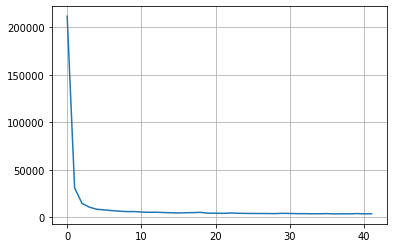

79/79 [==============================] - 0s 2ms/step


 14%|████████████                                                                        | 1/7 [00:16<01:41, 16.96s/it]

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 366)               134322    
                                                                 
 dropout_16 (Dropout)        (None, 366)               0         
                                                                 
 dense_25 (Dense)            (None, 732)               268644    
                                                                 
 dropout_17 (Dropout)        (None, 732)               0         
                                                                 
 dense_26 (Dense)            (None, 1)                 733       
                                                                 
Total params: 403,699
Trainable params: 403,699
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 213938.8906 - 704m

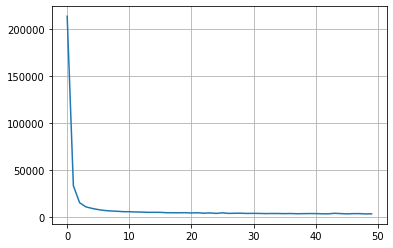

79/79 [==============================] - 0s 3ms/step


 29%|████████████████████████                                                            | 2/7 [00:37<01:34, 18.84s/it]

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 366)               134322    
                                                                 
 dropout_18 (Dropout)        (None, 366)               0         
                                                                 
 dense_28 (Dense)            (None, 732)               268644    
                                                                 
 dropout_19 (Dropout)        (None, 732)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 733       
                                                                 
Total params: 403,699
Trainable params: 403,699
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 210425.8438 - 702m

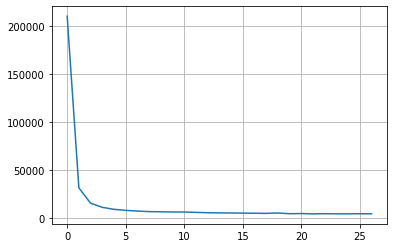

79/79 [==============================] - 0s 2ms/step


 43%|████████████████████████████████████                                                | 3/7 [00:48<01:01, 15.42s/it]

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 366)               134322    
                                                                 
 dropout_20 (Dropout)        (None, 366)               0         
                                                                 
 dense_31 (Dense)            (None, 732)               268644    
                                                                 
 dropout_21 (Dropout)        (None, 732)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 733       
                                                                 
Total params: 403,699
Trainable params: 403,699
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 210999.5156 - 752

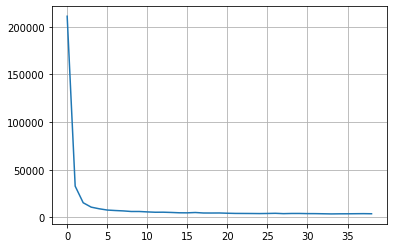

79/79 [==============================] - 0s 2ms/step


 57%|████████████████████████████████████████████████                                    | 4/7 [01:04<00:46, 15.47s/it]

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 366)               134322    
                                                                 
 dropout_22 (Dropout)        (None, 366)               0         
                                                                 
 dense_34 (Dense)            (None, 732)               268644    
                                                                 
 dropout_23 (Dropout)        (None, 732)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 733       
                                                                 
Total params: 403,699
Trainable params: 403,699
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 217013.6406 - 702

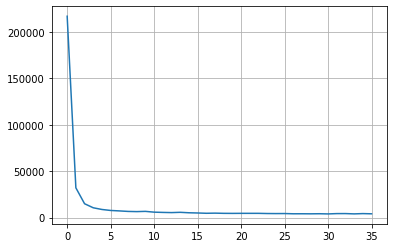

79/79 [==============================] - 0s 2ms/step


 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:19<00:30, 15.40s/it]

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 366)               134322    
                                                                 
 dropout_24 (Dropout)        (None, 366)               0         
                                                                 
 dense_37 (Dense)            (None, 732)               268644    
                                                                 
 dropout_25 (Dropout)        (None, 732)               0         
                                                                 
 dense_38 (Dense)            (None, 1)                 733       
                                                                 
Total params: 403,699
Trainable params: 403,699
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 210438.9062 - 707

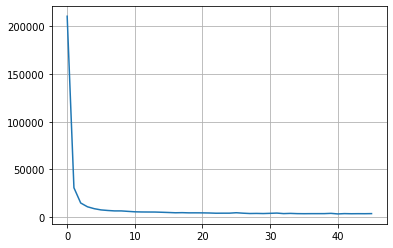

79/79 [==============================] - 0s 2ms/step


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [01:37<00:16, 16.27s/it]

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 366)               134322    
                                                                 
 dropout_26 (Dropout)        (None, 366)               0         
                                                                 
 dense_40 (Dense)            (None, 732)               268644    
                                                                 
 dropout_27 (Dropout)        (None, 732)               0         
                                                                 
 dense_41 (Dense)            (None, 1)                 733       
                                                                 
Total params: 403,699
Trainable params: 403,699
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 - 1s - loss: 214145.0312 - 712

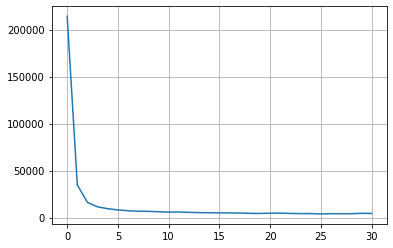

79/79 [==============================] - 0s 2ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:49<00:00, 15.69s/it]


In [31]:
VERBOSE = 2

with tf.device("/device:CPU:0"):
    
    for day_num in tqdm(range(1, 1 + max(SELECTED))):

        if day_num == 1:
                        
            train_all = []
            train_all = raw.iloc[:,:1]

            # Price에 Outlier Treatment 적용 ---------------------#

            winsor_list = []
            winsor_list.append(WINSOR)
            winsor_list.append(100 - WINSOR)

            winsors = np.percentile(train_all['Price'][train_all.index < BASEDATE], winsor_list)
            winsor_min = winsors[0]
            winsor_max = winsors[1]

            train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] < winsor_min, winsor_min, train_all['Price'][train_all.index < BASEDATE])
            train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] > winsor_max, winsor_max, train_all['Price'][train_all.index < BASEDATE])

            #-----------------------------------------------------#

            V = pd.DataFrame(columns=['V'],index=raw.index)
            for i in range(day_num, IRANGE + day_num):
                train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)

            raw_all = train_all.iloc[day_num:]

            if VARS == 2:  # 거래량을 사용할 경우에만 처리
                V['Volume'] = raw['Volume'].shift(day_num)
                V['Volume'].iloc[day_num:]
                raw_final = pd.concat([raw_all,V['Volume']],axis=1)
            else:
                raw_final = raw_all

            raw_final = raw_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

            train_new = raw_final[raw_final.index < BASEDATE]
            test_new = raw_final[raw_final.index >= BASEDATE]

            y_train_raw = train_new['Price']
            x_train_raw = train_new.drop(['Price'],axis=1)   

            # Min-Max Normalization 적용
            scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
            X_train = scaler_X_tr.fit_transform(x_train_raw)
                        
            joblib.dump(scaler_X_tr,f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}.save')                    

             # Validation 데이터을 학습에 사용할 경우에 대한 처리        

            if SPLIT == 0:
                x_train = X_train
                y_train = y_train_raw
            else:
                x_train = X_train[:-SPLIT]
                y_train = y_train_raw[:-SPLIT]
                x_valid = X_train[-SPLIT:]
                y_valid = y_train_raw[-SPLIT:]        

            # MLP Training

            model = Sequential()
            model.add(Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='elu'))
            model.add(Dropout(DROPOUT))
            model.add(Dense(2*(X_train.shape[1]), activation='elu'))
            model.add(Dropout(DROPOUT))
            model.add(Dense(1,activation='linear'))
            model.compile(optimizer='adam', loss='mean_squared_error')
            model.summary()

            if SPLIT == 0:
                ES = EarlyStopping(monitor='loss', mode='min', patience=PATIENCE, restore_best_weights=True)        
                model_fit = model.fit(x_train, y_train, 
                                      batch_size=BATCH, epochs=EPOCH, callbacks=ES,
                                      verbose=VERBOSE)
            else:
                ES = EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)        
                model_fit = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                                      batch_size=BATCH, epochs=EPOCH, callbacks=ES,
                                      verbose=VERBOSE)            
            
            # Save model
            model.save(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}')

            plt.plot(pd.DataFrame(model_fit.history))
            plt.grid(True)
            plt.show()            
            
            # Prediction
            Y_train_pred = model.predict(X_train)

        else:

            train_all = []
            train_all = raw.iloc[:,:1]

            V = pd.DataFrame(columns=['V'],index=raw.index)
            for i in range(day_num, IRANGE + 1):
                train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)

            train_new = train_new.iloc[:,:day_num-1]

            for call_train in range(1, day_num-1):
                train_new[f'Y_{call_train}pred'] = train_new[f'Y_{call_train}pred'].shift(1)

            train_new[f'Y_{day_num-1}pred'] = 0
            train_new[f'Y_{day_num-1}pred'] = Y_train_pred
            train_new[f'Y_{day_num-1}pred'] = train_new[f'Y_{day_num-1}pred'].shift(1)

            new = train_new.columns[-1:].to_list()
            Price = train_new.columns[:1].to_list()
            old = train_new.columns[1:day_num-1].to_list()
            new_col = Price + new + old
            train_new = train_new[new_col]

            train_new.fillna(method='bfill',inplace=True)

            raw_all = train_all.iloc[day_num:]

            train_all = train_all.drop('Price', axis=1)

            if VARS == 2:  # 거래량을 사용할 경우에만 처리
                V['Volume'] = raw['Volume'].shift(day_num)
                V['Volume'].iloc[day_num:]
                raw_final = pd.concat([train_new, train_all, V['Volume']],axis=1)
            else:
                raw_final = pd.concat([train_new, train_all],axis=1)

            raw_final = raw_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

            train_new = raw_final[raw_final.index < BASEDATE]
            test_new = raw_final[raw_final.index >= BASEDATE]        

            # Min-Max Normalization 적용
            scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
            X_train = scaler_X_tr.fit_transform(x_train_raw)
                        
            joblib.dump(scaler_X_tr,f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}.save')
                        
             # Validation 데이터을 학습에 사용할 경우에 대한 처리        

            if SPLIT == 0:
                x_train = X_train
                y_train = y_train_raw
            else:
                x_train = X_train[:-SPLIT]
                y_train = y_train_raw[:-SPLIT]
                x_valid = X_train[-SPLIT:]
                y_valid = y_train_raw[-SPLIT:]        

            # MLP Training

            model = Sequential()
            model.add(Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='elu'))
            model.add(Dropout(DROPOUT))
            model.add(Dense(2*(X_train.shape[1]), activation='elu'))
            model.add(Dropout(DROPOUT))
            model.add(Dense(1,activation='linear'))
            model.compile(optimizer='adam', loss='mean_squared_error')
            model.summary()

            if SPLIT == 0:
                ES = EarlyStopping(monitor='loss', mode='min', patience=PATIENCE, restore_best_weights=True)        
                model_fit = model.fit(x_train, y_train, 
                                      batch_size=BATCH, epochs=EPOCH, callbacks=ES,
                                      verbose=VERBOSE)
            else:
                ES = EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)        
                model_fit = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                                      batch_size=BATCH, epochs=EPOCH, callbacks=ES,
                                      verbose=VERBOSE)            
            
            # Save model
            model.save(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}')

            plt.plot(pd.DataFrame(model_fit.history))
            plt.grid(True)
            plt.show()            
            
            # Prediction
            Y_train_pred = model.predict(X_train) 


# MLP without FE / Inference

In [32]:
import datetime
print(datetime.datetime.now())

pred = []
DCNT = test.shape[0]

scaler = []
load_model = []

pos = 0

# lag변수 생성 
for i in range(1, IRANGE + 1):
    df[f'Price{i}lag'] = df['Price'].shift(i)
    

# Scaler 및 Model 사전 메모리 로드
for m in range(1, max(SELECTED) + 1):
    scaler_temp = joblib.load(f'./{SCALE_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{m}.save')
    model_temp = keras.models.load_model(f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{m}')
    
    scaler.append(scaler_temp)
    load_model.append(model_temp)    

    
    
with tf.device("/device:GPU:0"):  

    for day_num in tqdm(SELECTED):
        
        pos = pos + 1
        pred_list = []

        for valid_day in range(0, DCNT):
            
            target_date = test.index[0] + datetime.timedelta(days = -day_num + valid_day)
            df_x = df.iloc[df.index <= target_date, 2:]

            V = VS[VS.index == target_date]
            
            for model_day in range(1, day_num + 1):                
                
                if model_day == 1:

                    test_new = df_x[-1:]
                    
                    if VARS == 2:  # 거래량을 사용할 경우에만 처리
                        raw_final = pd.concat([test_new, V['Volume']],axis=1)
                    else:
                        raw_final = pd.concat([test_new],axis=1)

                    x_test = scaler[model_day-1].transform(raw_final)
                    y_test_pred = load_model[model_day-1].predict(x_test, verbose=0)

                    temp = raw_final.iloc[:, 0:IRANGE]                    
                                        
                else:
                    
                    temp.index = temp.index + datetime.timedelta(days=1)

                    for mov in range(IRANGE, 2, -1):
                        temp[f'Price{mov}lag'] = temp[f'Price{mov-1}lag']

                    temp['Price1lag'] = y_test_pred
                    df_x = df_x.append(temp)

                    test_new = df_x[-1:]
                    V.index = temp.index

                    if VARS == 2:  # 거래량을 사용할 경우에만 처리
                        raw_final = pd.concat([test_new, V['Volume']],axis=1)
                    else:
                        raw_final = pd.concat([test_new],axis=1)

                    x_test = scaler[model_day-1].transform(raw_final)
                    y_test_pred = load_model[model_day-1].predict(x_test, verbose=0)
            
            pred_list.append(y_test_pred[0])

        pred.append(pred_list)

print(datetime.datetime.now())

2022-08-09 00:51:02.412481


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [04:18<00:00, 129.09s/it]

2022-08-09 00:55:23.424083


# MLP without FE / Visualization

Model5 Results



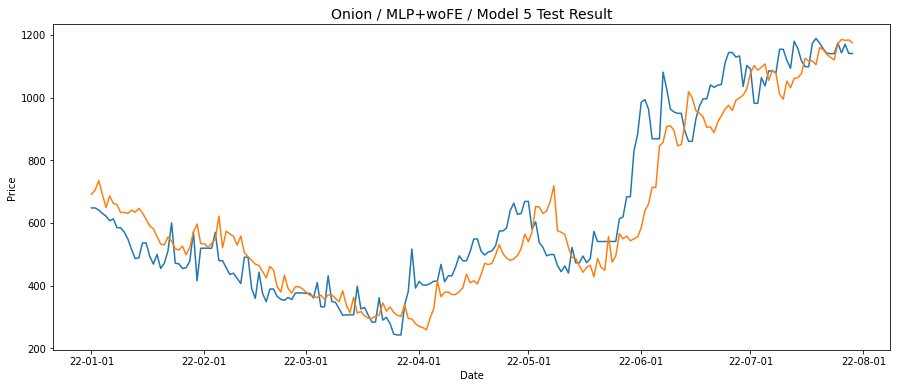

MAPE=13.355180602883369
RMSE=100.9564214870273



Model7 Results



<Figure size 432x288 with 0 Axes>

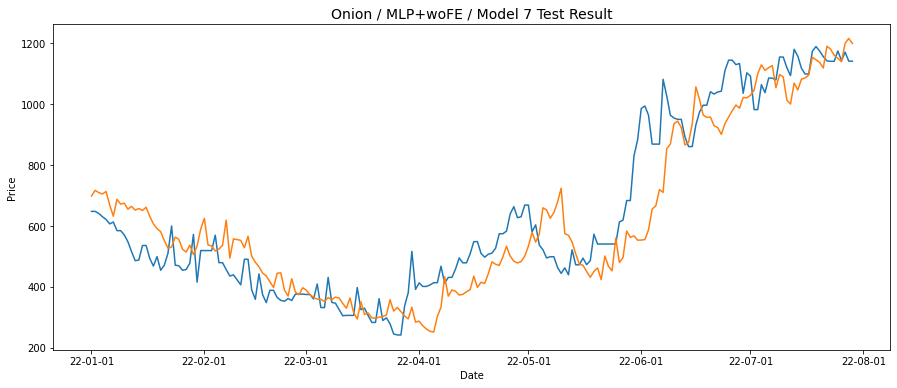

MAPE=15.09453603935826
RMSE=112.46329749111094





<Figure size 432x288 with 0 Axes>

In [33]:
for i in range(0, NSEL):
    
    print(f'Model{SELECTED[i]} Results\n')

    plot_data = pd.DataFrame([y_test.values, pred[i]]).T
    date_label = pd.date_range(start=y_test.index[0], end=y_test.index[-1], freq='D')
    
    fig, ax = plt.subplots(figsize=(15,6))
        
    plot_data.columns = ['actual','pred']
    ax.plot(date_label, plot_data)
    
    plt.title(PDNAME + ' / ' + MDCODE + '+woFE / Model ' + str(SELECTED[i]) + ' Test Result', fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)
    
    dateFmt = mdates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(dateFmt)
    
    plt.show()
    plt.clf()
    
    MAPE = mean_absolute_percentage_error(y_test.values.flatten(), pred[i])*100
    print(f'MAPE={MAPE}')

    RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(), pred[i]))
    print(f'RMSE={RMSE}\n\n\n')